In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 4
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import seaborn as sns
from sklearn.decomposition import PCA

In [13]:
df = pd.read_csv('../data/all_data.csv')
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())

In [14]:
df = df.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail/recreation','grocery_and_pharmacy_percent_change_from_baseline': 'grocery/pharmacy','parks_percent_change_from_baseline':'parks','workplaces_percent_change_from_baseline':'workplaces','residential_percent_change_from_baseline':'residential'})
df = df.drop(columns='transit_stations_percent_change_from_baseline')
df = df.dropna()


In [15]:
pca = PCA(n_components=2)
df['department_name'] = df['department_name'].apply(lambda x: " ".join(x.split(' ')[:-1]))
X_transformed = pca.fit_transform(df[df.columns[np.r_[1:5,5:6]]])
df['component_1'] = X_transformed[:,0]
df['component_2'] = X_transformed[:,1]
df['intercept'] = 1
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())

In [16]:
X_depts, y_depts = [], []
time_vecs = []
date_vecs = []
for n, dept in enumerate(groups):
    df_dept = grouped_df.get_group(dept)
    df_dept = df_dept.sort_values('date')
    date_vecs.append(df_dept['date'])
    X = df_dept[['intercept','component_1','component_2']].to_numpy()
    y = df_dept['incidents'].to_numpy()
    X_depts.append(X)
    y_depts.append(y.flatten())
    df_dept['day_of_the_year'] = pd.to_datetime(df_dept['date']).dt.day_of_year
    time_vecs.append(df_dept['day_of_the_year'].to_numpy())

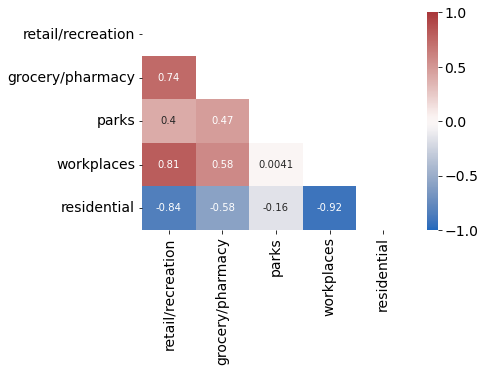

In [19]:
plt.plot(facecolor='white')
df_corr = df[['retail/recreation','grocery/pharmacy','parks','workplaces','residential']]
sns.heatmap(df_corr.corr(), cmap='vlag',vmin=-1, vmax=1, annot=True, mask=np.triu(df_corr.corr()))
plt.savefig('../writeup/corr.png',dpi=300, bbox_inches='tight')

In [60]:
# plot first two components
components = pd.DataFrame(np.round(pca.components_, 3))
components.columns = df.columns[1:6]
components

,retail/recreation,grocery/pharmacy,parks,workplaces,residential
0,0.108,0.080,0.991,0.008,-0.018
1,0.646,0.311,-0.106,0.639,-0.258


In [27]:
pca.explained_variance_ratio_.sum()

0.9851171216636357

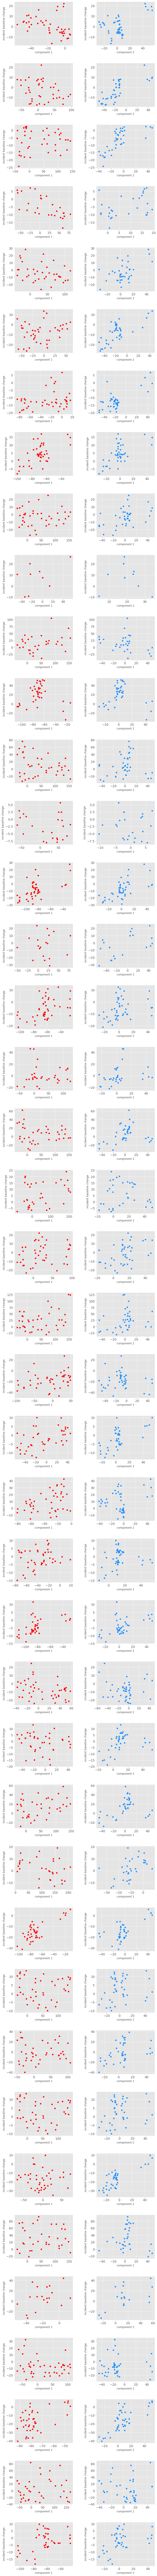

In [30]:
plt.figure(figsize=(30, 200))
plt.style.use('ggplot')
colors = ['red','dodgerblue']
for n, dept in enumerate(groups):
    X, y = X_depts[n][:,1:], y_depts[n]
    for i in range(X.shape[1]):
        plt.subplot(len(groups), 5, 5*n+i + 1)
        plt.scatter(X[:,i], y, color = colors[i])
        plt.ylabel('incident baseline change')
        plt.xlabel(f'component {i+1}')
        if i ==2:
            plt.title(dept)
            
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)    
    


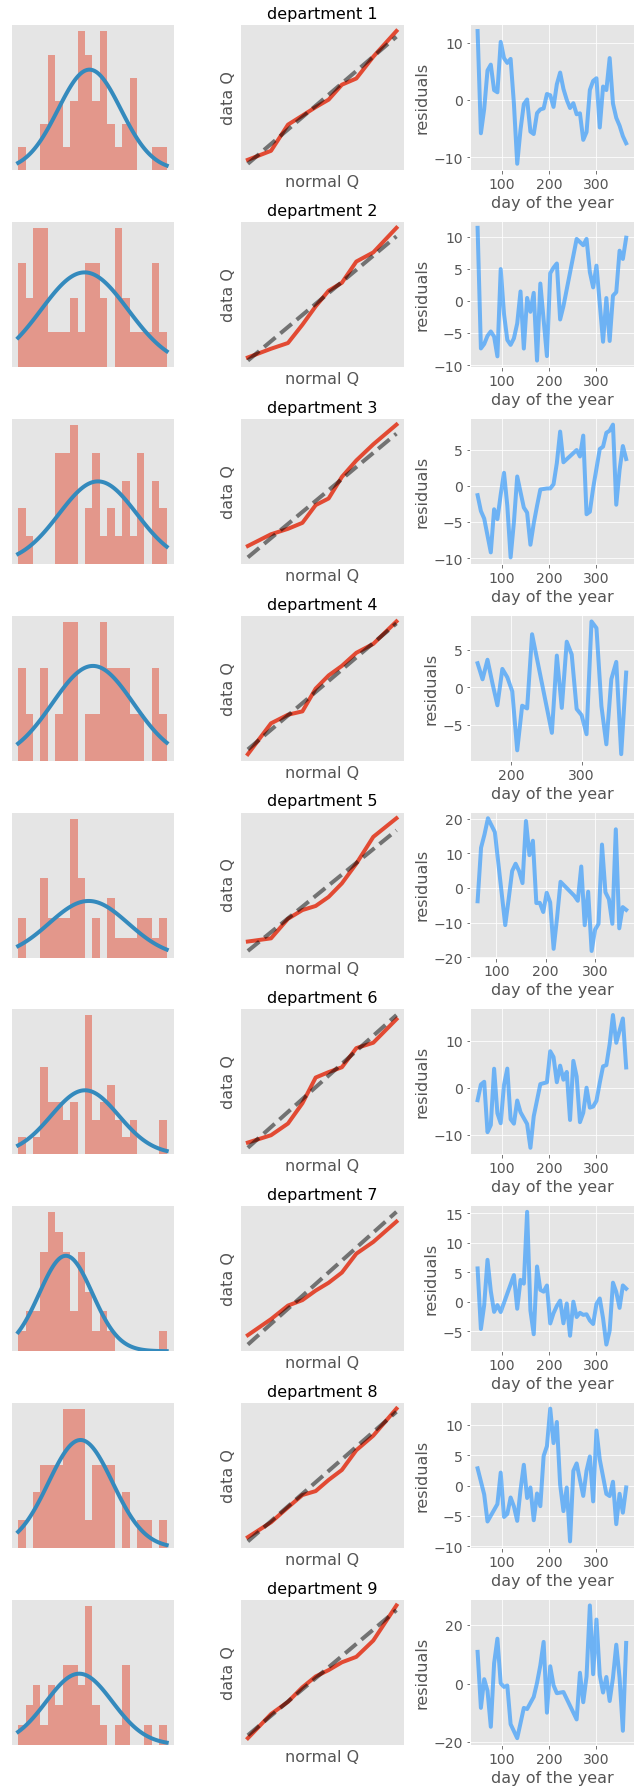

In [37]:
plt.figure(figsize=(9, 25))
all_residuals = []
    
for n, dept in enumerate(groups[0:9]):
    plt.subplot(9, 3, 3*n + 1)
    X, y = X_depts[n][:,1:], y_depts[n]
    reg = LinearRegression()
    reg.fit(X, y)
    residuals = y - reg.predict(X)
    all_residuals.append(residuals)
    plt.hist(residuals, alpha=.5, density=True, bins=20)
    plt.xticks([])
    plt.yticks([])
    
    mean = np.mean(residuals)
    var = np.var(residuals)
    min_x, max_x = np.min(residuals), np.max(residuals)
    x = np.linspace(min_x, max_x, 100)
    normal = norm(loc=mean, scale=np.sqrt(var))
    norm_pdf = normal.pdf(x)
    plt.plot(x, norm_pdf)
    plt.subplot(9, 3, 3*n + 2)
    plt.title(f'department {n+1}')

    
    quants = np.linspace(0.1, 0.9, 10)
    quantiles_norm = normal.ppf(quants)
    quantiles_data = np.quantile(residuals, quants)
    plt.plot(quantiles_norm, quantiles_data)
    plt.xlabel('normal Q')
    plt.ylabel('data Q')
    plt.xticks([])
    plt.yticks([])
    plt.plot([quantiles_norm.min(), quantiles_norm.max()],[quantiles_norm.min(), quantiles_norm.max()], color='black', alpha=.5, linestyle='--')
    plt.subplot(9, 3, 3*n + 3)
    plt.plot(time_vecs[n], residuals, alpha=.6, color='dodgerblue')
    plt.xlabel('day of the year')
    plt.ylabel('residuals')
    
plt.tight_layout()    
    
plt.savefig('../writeup/normal_approx_1.png',bbox_inches='tight', dpi=300)
    
    
    
    
    

In [38]:
all_days_2020 = pd.DataFrame(pd.date_range("2020", freq="D", periods=365))
all_days_2020.columns = ['date']
mondays_of_2020 = all_days_2020[all_days_2020['date'].dt.dayofweek == 0].reset_index()

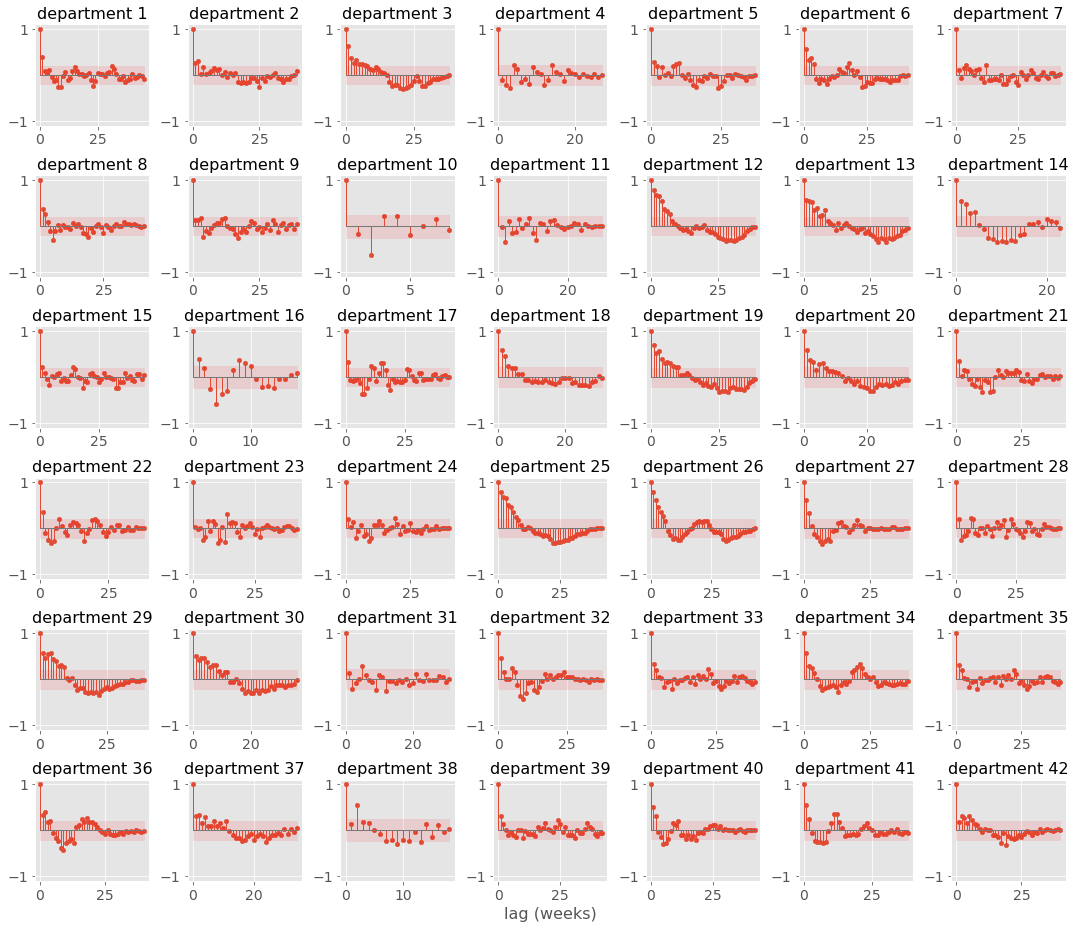

In [58]:
plt.figure(figsize=(15, 13))

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
corr_dfs = []
for i in range(len(groups)):
    plt.subplot(6, 7, i + 1)
    reg = LinearRegression()
    reg.fit(X_depts[i], y_depts[i])
    residuals = y_depts[i] - reg.predict(X_depts[i])
    df_corr = pd.DataFrame(data = np.vstack([time_vecs[i], residuals]).T)
    df_corr.columns = ['date', 'residual']
    df_corr['date'] =  pd.to_datetime(df_corr['date'])
    merged_df = pd.merge(mondays_of_2020, df_corr, how='outer', on='date')
    corr_dfs.append(merged_df)
    data, CI = acf(merged_df['residual'],  nlags=len(residuals)-1,  missing='drop', alpha=.05, bartlett_confint = False
)
    lags = np.arange(0, len(residuals), 1)
    plt.scatter(lags, data, s=20)
    _, stemlines, baseline = plt.stem(lags, data, markerfmt=' ')
    plt.setp(stemlines, 'linewidth', 1)
    plt.setp(baseline, 'linewidth', 1)
    plt.ylim(-1.1,1.1)
    plt.yticks([-1,1])
    plt.fill_between(lags,CI[:,0]-data, CI[:,1]-data, alpha=.1, color='red')
    plt.title(f'department {i+1}')
    if i == 38:
        plt.xlabel('lag (weeks)')
    
plt.tight_layout()
plt.savefig('acf_plots.png',bbox_inches='tight', dpi=200)   
   